In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [3]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

training examples = 2323, testing examples = 259


## Model-Building and Evaluation

In [87]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=train_df["prob_of_release"],
                       lower=0, upper=1, shape=features.shape[1])

In [88]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


In [89]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.11,0.01,0.10,0.12,0.00,0.00,1937.48,1741.01,1.00
WD_Thursday,0.06,0.37,-0.64,0.75,0.02,0.01,516.49,657.32,1.01
WD_Wednesday,0.05,0.37,-0.65,0.73,0.02,0.01,514.26,656.63,1.01
month_holidays,0.01,0.01,-0.00,0.02,0.00,0.00,2521.35,1868.93,1.00
WD_Friday,0.01,0.37,-0.71,0.68,0.02,0.01,515.65,676.52,1.01
WD_Tuesday,0.00,0.37,-0.70,0.68,0.02,0.01,516.92,695.23,1.01
WD_Monday,-0.05,0.37,-0.74,0.65,0.02,0.01,513.33,656.43,1.01
WD_Saturday,-0.05,0.37,-0.74,0.65,0.02,0.01,515.60,640.27,1.01
WD_Sunday,-0.07,0.37,-0.76,0.62,0.02,0.01,514.65,672.99,1.01


### Out-of-Sample Evaluation

In [91]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


In [92]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [93]:
mape(test_df["prob_of_release"], y_pred)

0.27787906105254034

In [94]:
wape(test_df["prob_of_release"], y_pred)

0.2301527771566223

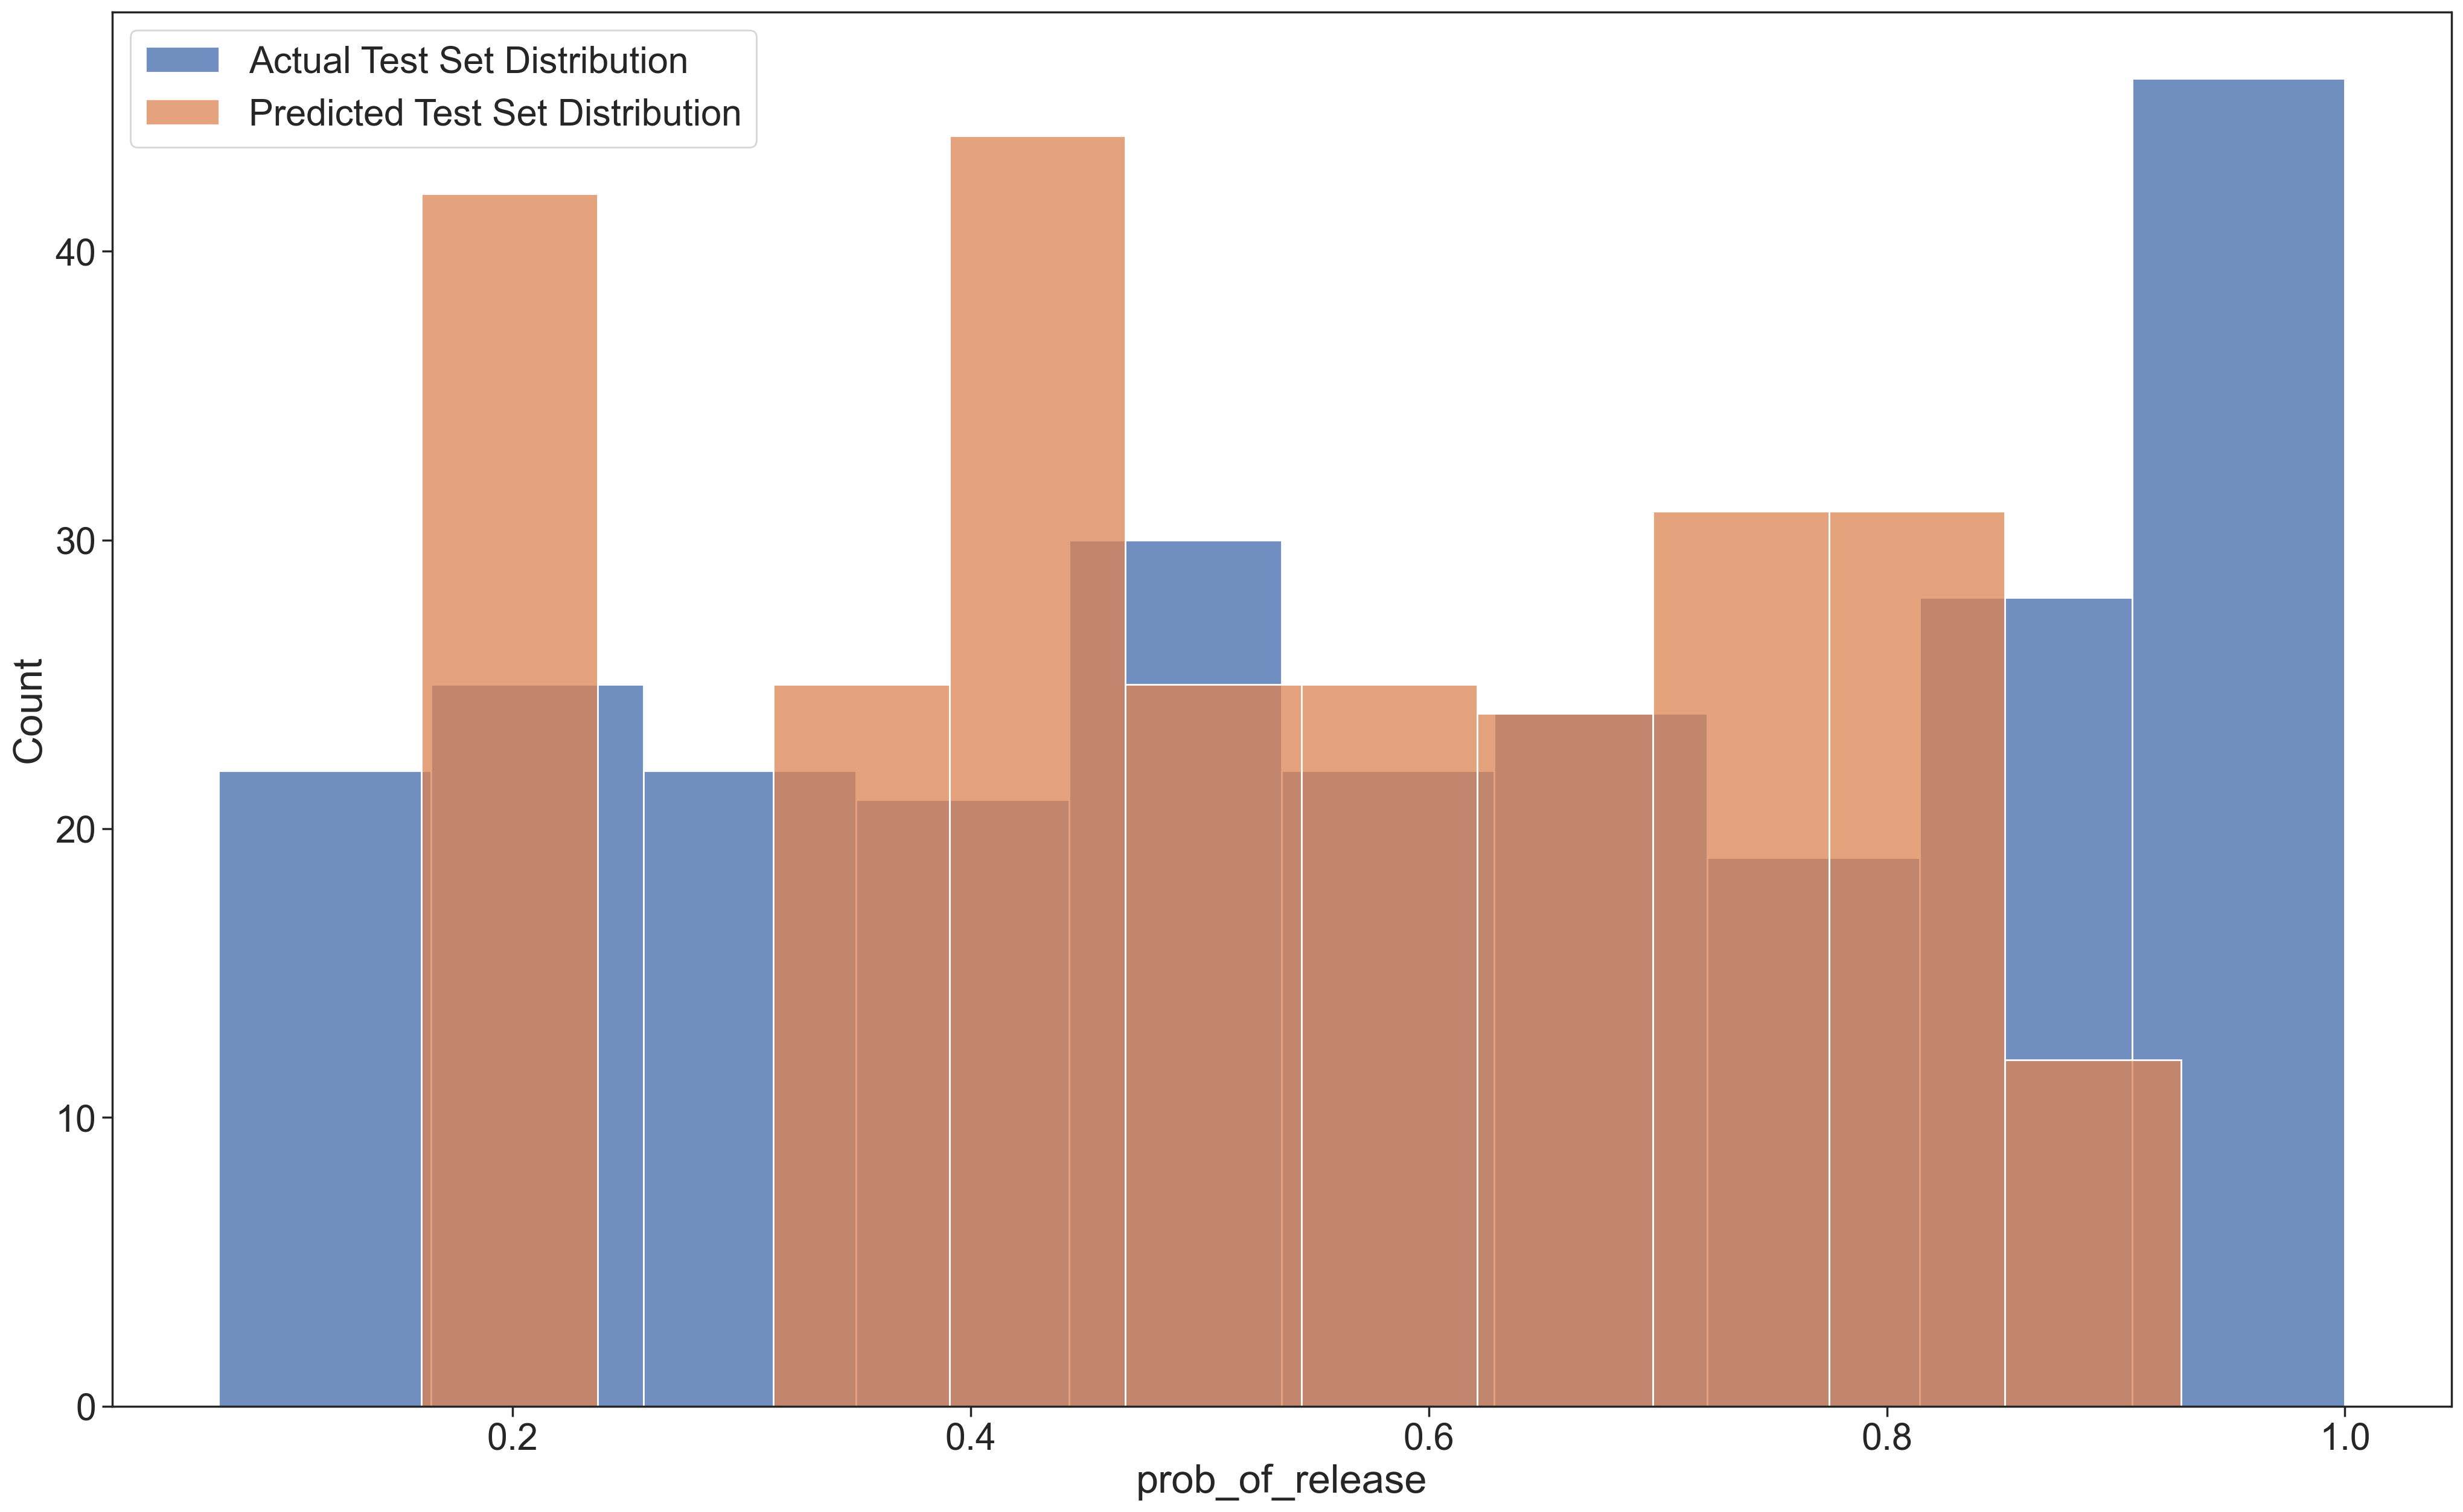

In [95]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=y_pred, ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Month

In [96]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [97]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [98]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.11,0.01,0.11,0.12,0.00,0.00,1585.45,1467.79,1.00
WD_Thursday,0.09,0.37,-0.61,0.79,0.02,0.01,586.71,807.99,1.01
WD_Wednesday,0.08,0.37,-0.63,0.76,0.02,0.01,585.87,802.93,1.01
WD_Friday,0.05,0.37,-0.67,0.72,0.02,0.01,591.24,822.13,1.01
WD_Tuesday,0.03,0.37,-0.68,0.71,0.02,0.01,584.02,778.77,1.01
month_holidays,0.01,0.01,-0.00,0.02,0.00,0.00,2103.24,2020.32,1.00
WD_Monday,-0.03,0.37,-0.75,0.65,0.02,0.01,584.07,810.36,1.01
WD_Saturday,-0.03,0.37,-0.73,0.66,0.02,0.01,582.59,827.40,1.01
WD_Sunday,-0.05,0.37,-0.74,0.65,0.02,0.01,580.34,802.70,1.01


In [99]:
with model:
    pm.set_data({"features" : next_month[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


In [100]:
next_month["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [101]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_month["predicted_min"] = hdi["y_pred"][:, 0]
next_month["predicted_max"] = hdi["y_pred"][:, 1]

In [102]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
1,2024-03-15,0.0000,0.1942,0.4818
2,2024-03-16,0.0006,0.3629,0.7373
3,2024-03-17,0.0174,0.4286,0.8262
4,2024-03-18,0.1408,0.5344,0.9793
5,2024-03-19,0.2784,0.6564,0.9950
6,2024-03-20,0.4253,0.7491,0.9998
7,2024-03-21,0.5065,0.8022,0.9999
8,2024-03-22,0.5491,0.8239,1.0000
9,2024-03-23,0.5735,0.8324,0.9996
10,2024-03-24,0.6194,0.8585,1.0000


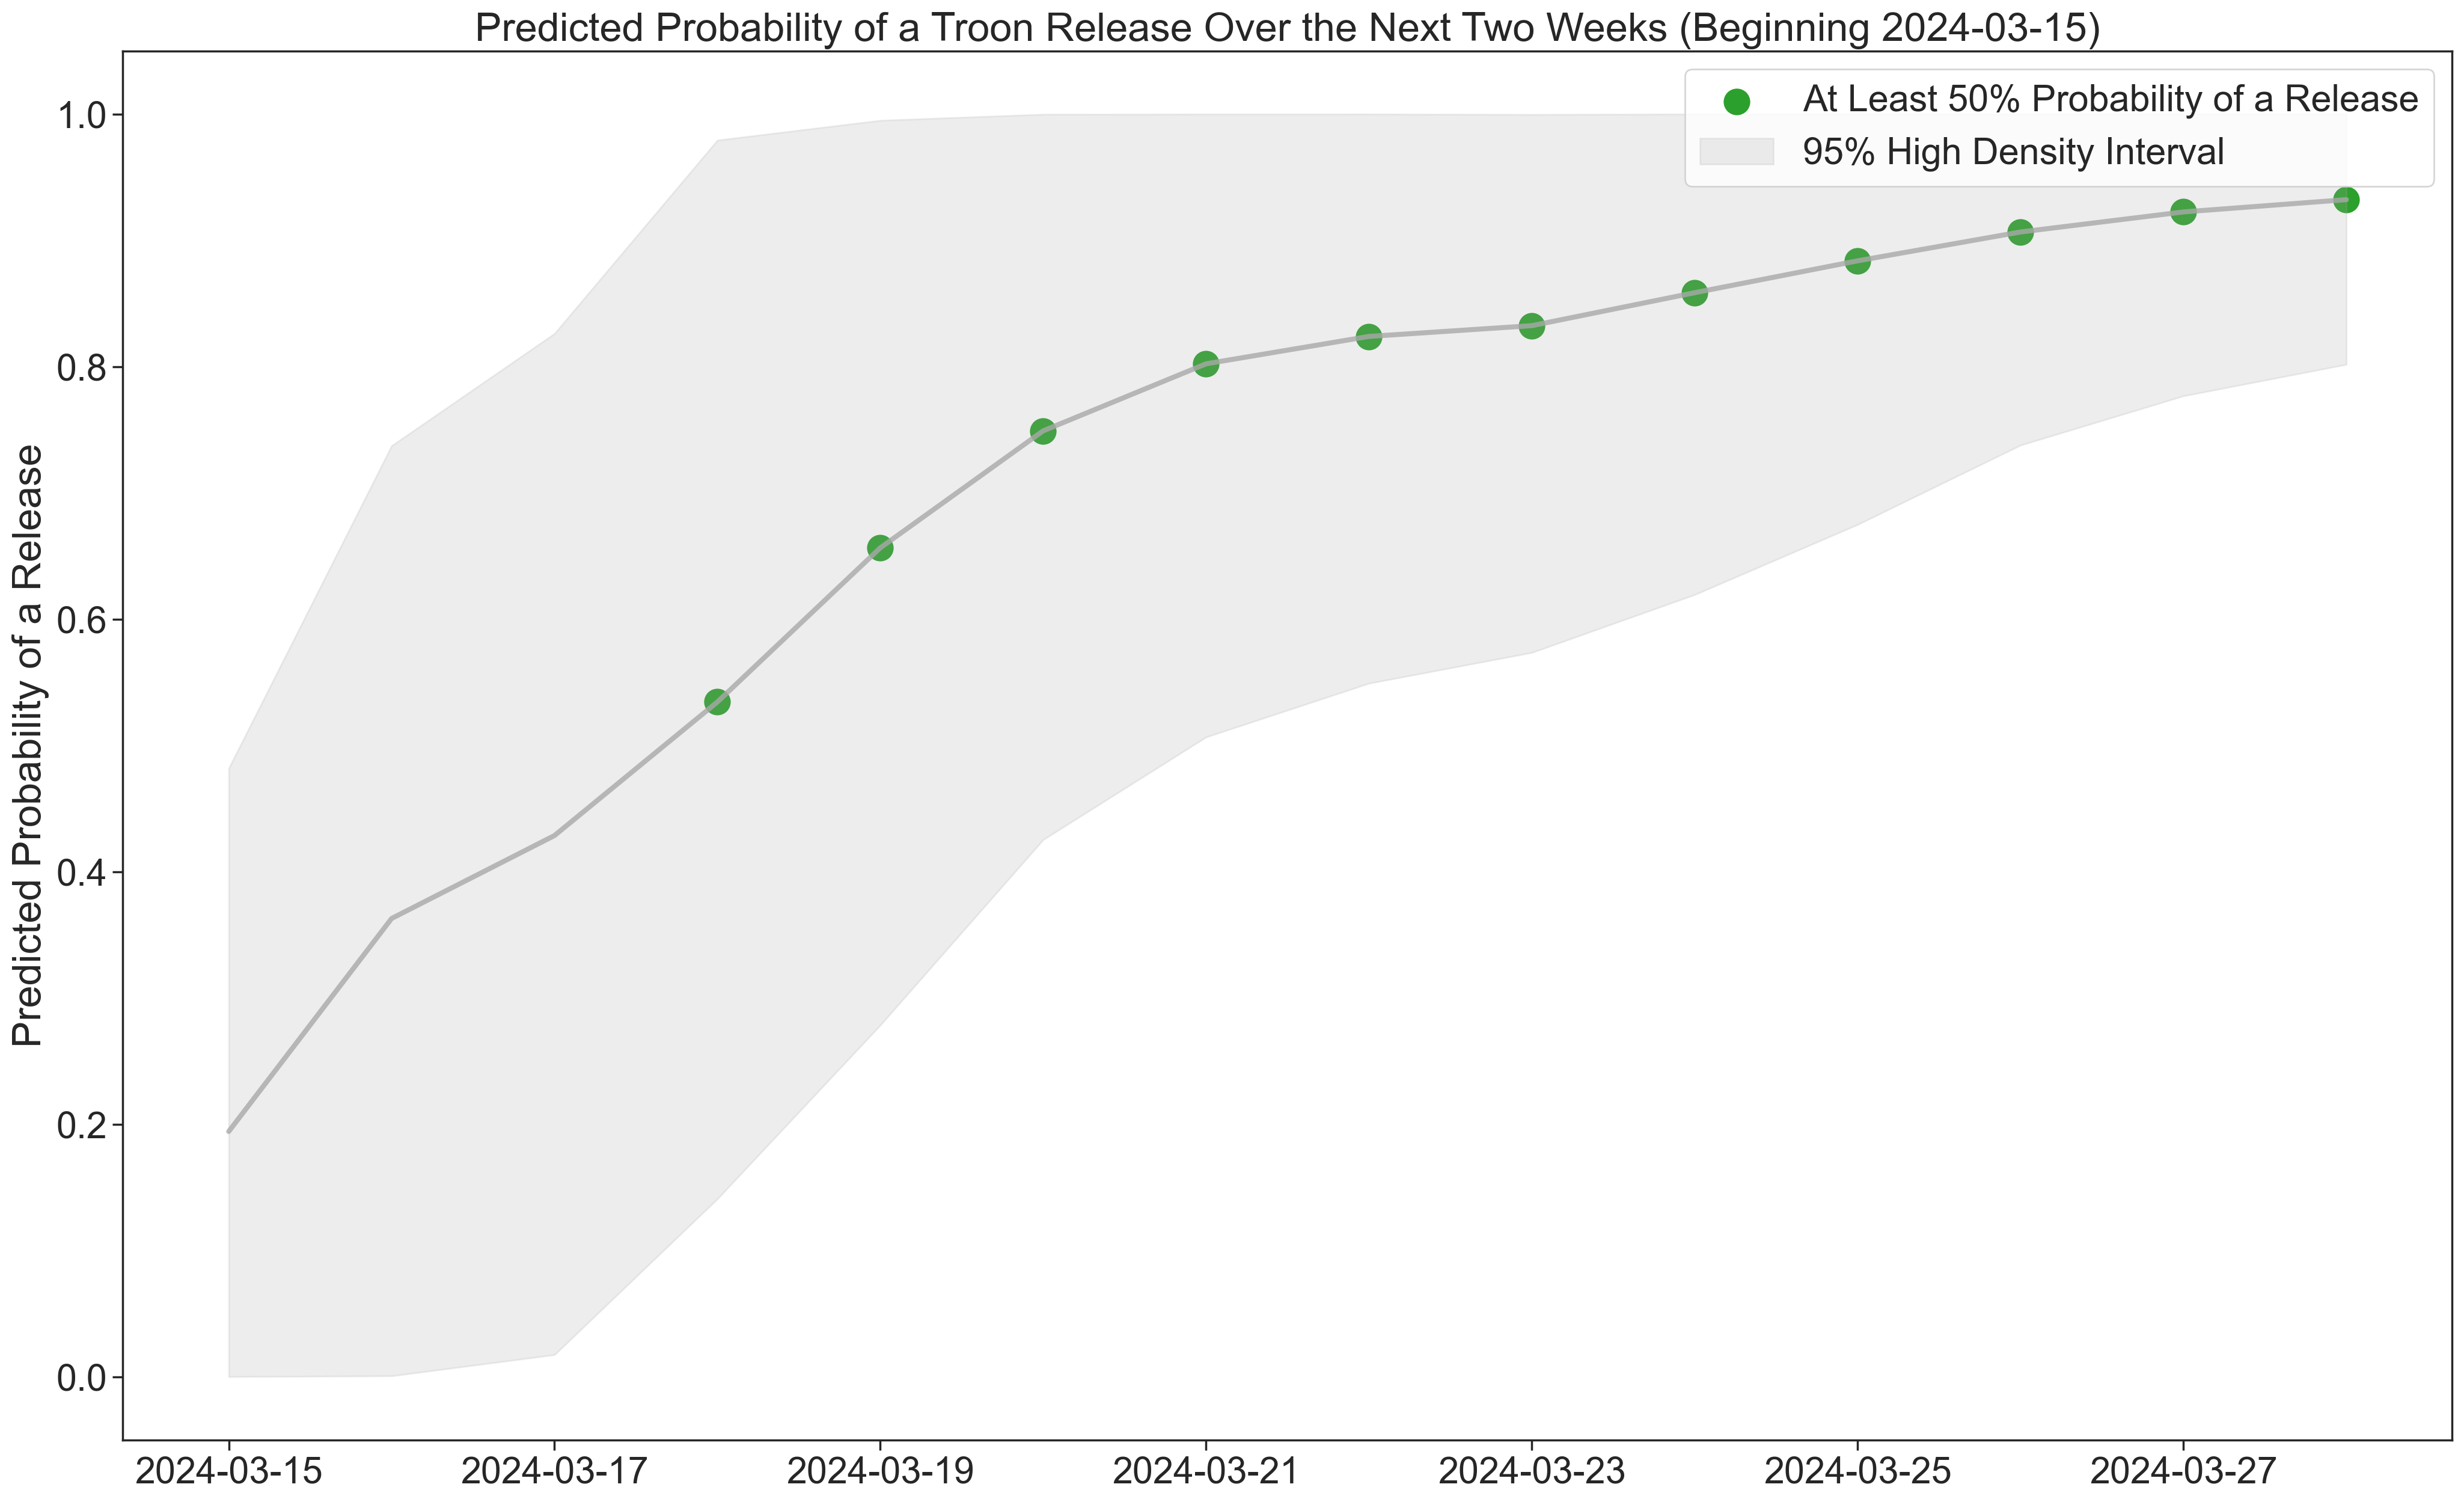

In [103]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()